
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh 

____

Parsa Hatami

400100962

# 🔴 **Import Libs**

In [1]:
!pip uninstall -y torch torchtext

!pip install torch==1.13.0 torchtext==0.14.0

Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 955.4 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 84.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.4.0 requires torch>=2.1.0, but you have torch 1.13.0 which is incompatible.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 1.13.0 whi

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [3]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
1.13.0+cu117
0.14.0


In [4]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 1.13.0+cu117
torchtext --> 0.14.0
tqdm --> 4.66.5


# 🔴 **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [7]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

print(dataset)

train_data = dataset["train"]
valid_data = dataset["validation"]
test_data = dataset["test"]

print("Sample from training data:")
print(train_data[0])


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
Sample from training data:
{'text': ''}


## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [8]:
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pickle

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text["text"])

train_iter = dataset["train"]
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>", "<bos>", "<eos>"])

vocab.set_default_index(vocab["<unk>"])

with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi())[:10]}")


Vocabulary size: 66061
Sample tokens: ['�', '／', 'ﻋ', '알라', '龍神村', '高円寺', '霹靂火砲', '雪のかなた', '陽子', '陈星汉']


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [9]:
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

tokenizer = get_tokenizer("basic_english")

def calculate_statistics(dataset_split):
    total_docs = len(dataset_split)
    total_words = 0
    doc_lengths = []

    for item in dataset_split:
        tokens = tokenizer(item["text"])
        total_words += len(tokens)
        doc_lengths.append(len(tokens))

    avg_doc_length = total_words / total_docs if total_docs > 0 else 0
    return total_docs, total_words, avg_doc_length

train_stats = calculate_statistics(dataset["train"])
valid_stats = calculate_statistics(dataset["validation"])
test_stats = calculate_statistics(dataset["test"])

print("Training Data Statistics:")
print(f"  Number of Documents: {train_stats[0]}")
print(f"  Total Words: {train_stats[1]}")
print(f"  Average Document Length: {train_stats[2]:.2f}")

print("\nValidation Data Statistics:")
print(f"  Number of Documents: {valid_stats[0]}")
print(f"  Total Words: {valid_stats[1]}")
print(f"  Average Document Length: {valid_stats[2]:.2f}")

print("\nTest Data Statistics:")
print(f"  Number of Documents: {test_stats[0]}")
print(f"  Total Words: {test_stats[1]}")
print(f"  Average Document Length: {test_stats[2]:.2f}")


Training Data Statistics:
  Number of Documents: 36718
  Total Words: 2051665
  Average Document Length: 55.88

Validation Data Statistics:
  Number of Documents: 3760
  Total Words: 214665
  Average Document Length: 57.09

Test Data Statistics:
  Number of Documents: 4358
  Total Words: 242156
  Average Document Length: 55.57


### 🟡 Analyze the most common and least common words in the dataset.

In [10]:
from collections import Counter

tokenizer = get_tokenizer("basic_english")

def analyze_word_frequencies(dataset_split):
    word_counter = Counter()

    for item in dataset_split:
        tokens = tokenizer(item["text"])
        word_counter.update(tokens)

    most_common = word_counter.most_common(10)
    least_common = word_counter.most_common()[-10:]

    return most_common, least_common

most_common_words, least_common_words = analyze_word_frequencies(dataset["train"])

print("Most Common Words:")
for word, freq in most_common_words:
    print(f"  {word}: {freq}")

print("\nLeast Common Words:")
for word, freq in least_common_words:
    print(f"  {word}: {freq}")


Most Common Words:
  the: 130770
  ,: 102624
  .: 84291
  of: 57032
  and: 50736
  in: 45018
  to: 39522
  a: 36564
  =: 29570
  was: 21008

Least Common Words:
  messy: 1
  branwen: 1
  tamed: 1
  bran: 1
  manawydan: 1
  holler: 1
  nay: 1
  kv: 1
  casseroled: 1
  pâté: 1


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

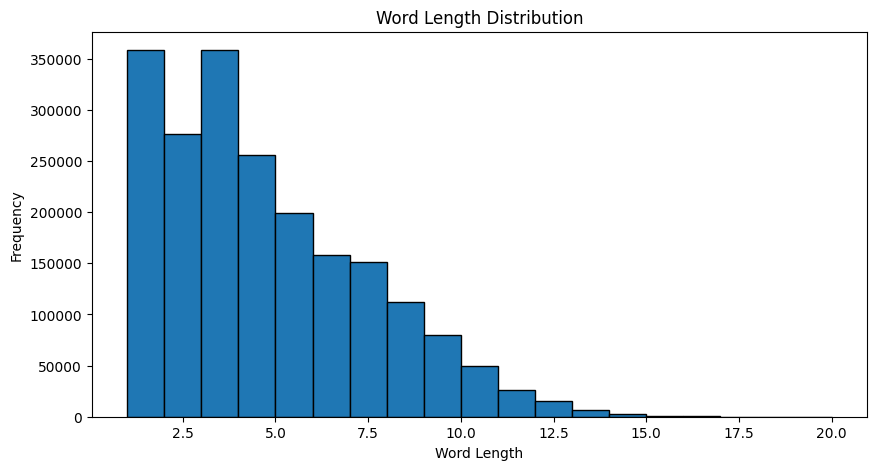

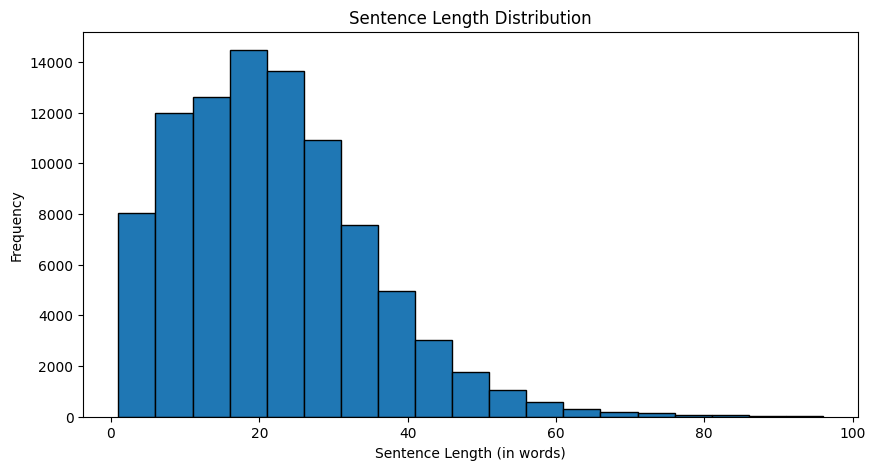

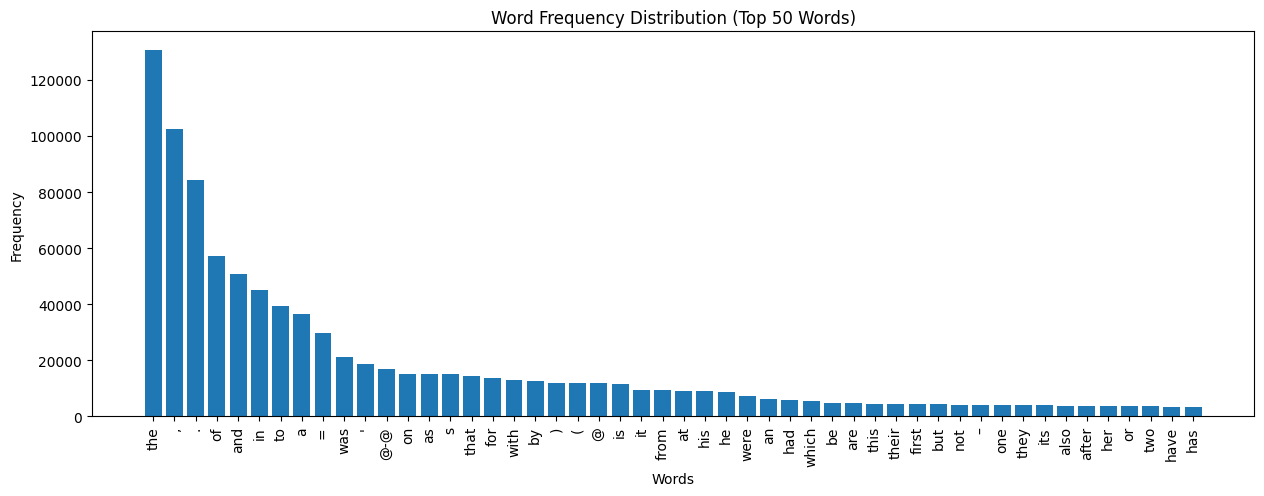

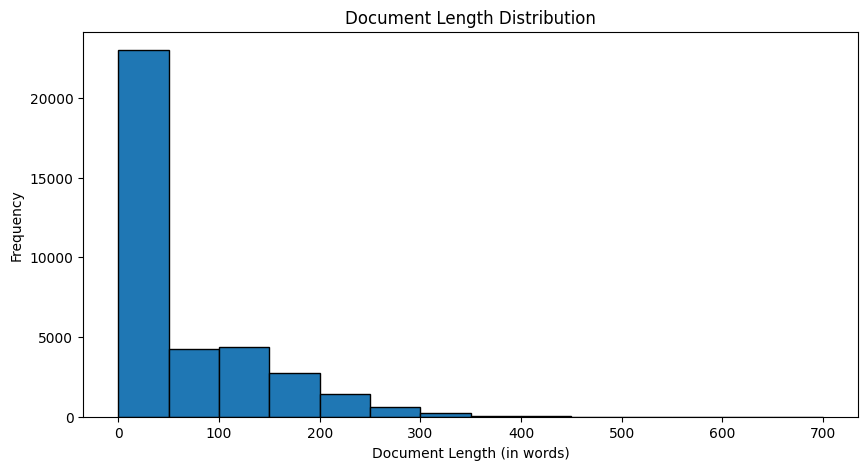

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

tokenizer = get_tokenizer("basic_english")

def analyze_word_length_distribution(dataset_split):
    word_lengths = []
    for item in dataset_split:
        tokens = tokenizer(item["text"])
        word_lengths.extend([len(word) for word in tokens])
    return word_lengths

def analyze_sentence_length_distribution(dataset_split):
    sentence_lengths = []
    for item in dataset_split:
        sentences = item["text"].split('.')
        for sentence in sentences:
            tokens = tokenizer(sentence)
            sentence_lengths.append(len(tokens))
    return sentence_lengths

def analyze_word_frequency_distribution(dataset_split):
    word_counter = Counter()
    for item in dataset_split:
        tokens = tokenizer(item["text"])
        word_counter.update(tokens)
    return word_counter

def analyze_document_length_distribution(dataset_split):
    document_lengths = []
    for item in dataset_split:
        tokens = tokenizer(item["text"])
        document_lengths.append(len(tokens))
    return document_lengths



word_lengths = analyze_word_length_distribution(dataset["train"])
sentence_lengths = analyze_sentence_length_distribution(dataset["train"])

word_frequencies = analyze_word_frequency_distribution(dataset["train"])
document_lengths = analyze_document_length_distribution(dataset["train"])

most_common_words = word_frequencies.most_common(50)
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 5))
plt.hist(word_lengths, bins=range(1, 21), edgecolor='black')
plt.title("Word Length Distribution")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins=range(1, 101, 5), edgecolor='black')
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(words, frequencies)
plt.title("Word Frequency Distribution (Top 50 Words)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(document_lengths, bins=range(0, max(document_lengths) + 50, 50), edgecolor='black')
plt.title("Document Length Distribution")
plt.xlabel("Document Length (in words)")
plt.ylabel("Frequency")
plt.show()

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [12]:
def data_process(raw_text_iter, batch_size, seq_len):
    token_list = []

    for entry in raw_text_iter:
        text_tokens = tokenizer(entry["text"])
        token_indices = vocab(text_tokens)
        token_list += token_indices

    token_tensor = torch.tensor(token_list, dtype=torch.long)

    adjusted_length = (len(token_tensor) // (batch_size * seq_len)) * (batch_size * seq_len)
    token_tensor = token_tensor[:adjusted_length + 1]

    input_data = token_tensor[:-1].view(batch_size, -1)
    target_data = token_tensor[1:].view(batch_size, -1)

    chunk_count = input_data.size(1) // seq_len
    inputs = input_data[:, :chunk_count * seq_len].contiguous().view(-1, seq_len)
    targets = target_data[:, :chunk_count * seq_len].contiguous().view(-1, seq_len)

    return inputs, targets

In [13]:
batch_size = 32
seq_len = 60

train_inputs, train_targets = data_process(dataset["train"], batch_size, seq_len)
valid_inputs, valid_targets = data_process(dataset["validation"], batch_size, seq_len)
test_inputs, test_targets = data_process(dataset["test"], batch_size, seq_len)

print(f"Train Inputs Shape: {train_inputs.shape}")
print(f"Train Targets Shape: {train_targets.shape}")
print(f"Validation Inputs Shape: {valid_inputs.shape}")
print(f"Validation Targets Shape: {valid_targets.shape}")
print(f"Test Inputs Shape: {test_inputs.shape}")
print(f"Test Targets Shape: {test_targets.shape}")

Train Inputs Shape: torch.Size([34176, 60])
Train Targets Shape: torch.Size([34176, 60])
Validation Inputs Shape: torch.Size([3552, 60])
Validation Targets Shape: torch.Size([3552, 60])
Test Inputs Shape: torch.Size([4032, 60])
Test Targets Shape: torch.Size([4032, 60])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [14]:
class LanguageModelDataset(Dataset):
    def __init__(self, inputs, targets):
        """
        Custom dataset for language modeling.
        
        Args:
            inputs (torch.Tensor): Input tensor of shape (N, B, L).
            targets (torch.Tensor): Target tensor of shape (N, B, L).
        """
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        """
        Returns the number of samples (N).
        """
        return self.inputs.size(0)

    def __getitem__(self, idx):
        """
        Retrieve a single sample by index.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Input and target tensors for the given index.
        """
        return self.inputs[idx], self.targets[idx]
        

In [15]:
train_dataset = LanguageModelDataset(train_inputs, train_targets)
valid_dataset = LanguageModelDataset(valid_inputs, valid_targets)
test_dataset = LanguageModelDataset(test_inputs, test_targets)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(valid_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


Train Dataset Size: 34176
Validation Dataset Size: 3552
Test Dataset Size: 4032


## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [16]:
def create_dataloader(dataset, batch_size, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

loader_batch_size = 32

train_loader = create_dataloader(train_dataset, loader_batch_size, shuffle=True)
valid_loader = create_dataloader(valid_dataset, loader_batch_size, shuffle=False)
test_loader = create_dataloader(test_dataset, loader_batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 1068
Number of validation batches: 111
Number of test batches: 126


# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [17]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_units, layer_count, drop_rate):
        super().__init__()
        
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_units,
            num_layers=layer_count,
            dropout=drop_rate,
            batch_first=True
        )
        
        self.output_layer = nn.Linear(in_features=hidden_units, out_features=vocab_size)

    def forward(self, input_seq):
        embedded_seq = self.embed(input_seq)
        
        lstm_output, _ = self.lstm(embedded_seq)
        
        logits = self.output_layer(lstm_output)
        
        return logits

In [18]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_rate = 0.2

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)

print(model)

LanguageModel(
  (embed): Embedding(66061, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=256, out_features=66061, bias=True)
)


# 🔴 **Config**

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [21]:
learning_rate = 0.001

embedding_dimension = 128
hidden_dimension = 256
number_of_layers = 2
dropout_probability = 0.2
learning_rate = 0.001
epochs = 10

vocab_size = len(vocab)

language_model = LanguageModel(
    vocab_size=vocab_size,
    embed_dim=embedding_dimension,
    hidden_units=hidden_dimension,
    layer_count=number_of_layers,
    drop_rate=dropout_probability
)

loss_criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])

optimizer = optim.Adam(params=language_model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
language_model.to(device)
loss_criterion.to(device)

def compute_perplexity(loss_value):
    return torch.exp(loss_value)

def calculate_accuracy(predictions, targets):
    _, predicted = torch.max(predictions, dim=2)
    correct = (predicted == targets).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

print(f"Model and criterion moved to: {device}")
print(f"Optimizer: {optimizer}")
print(f"Loss Function: {loss_criterion}")

Model and criterion moved to: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Loss Function: CrossEntropyLoss()


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [22]:
def train_one_epoch(model, loader, loss_func, optimizer, metric, current_epoch=None):
    """
    Trains the model for a single epoch.

    Args:
        model (nn.Module): The neural network model to train.
        loader (DataLoader): DataLoader for the training data.
        loss_func (nn.Module): Loss function to optimize.
        optimizer (Optimizer): Optimizer for updating model parameters.
        metric (Metric): Metric for evaluating model performance.
        current_epoch (int, optional): Current epoch number for progress display.

    Returns:
        tuple: Updated model, average training loss, and computed metric.
    """
    model.train()
    training_loss = AverageMeter()
    metric.reset()

    with tqdm(loader, desc=f'Epoch {current_epoch}' if current_epoch is not None else 'Training', unit='batch') as progress:
        for batch_inputs, batch_targets in progress:
            if current_epoch is not None:
                progress.set_description(f'Epoch {current_epoch}')

            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            predictions = model(batch_inputs)

            predictions = predictions.view(-1, predictions.size(-1))
            batch_targets = batch_targets.view(-1)

            loss = loss_func(predictions, batch_targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            training_loss.update(loss.item(), n=batch_targets.size(0))
            metric.update(predictions, batch_targets)

            progress.set_postfix({
                'Loss': training_loss.avg,
                'Metric': metric.compute().item()
            })

    return model, training_loss.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [23]:
def evaluate(model, loader, loss_func, metric):
    """
    Evaluates the model's performance on the test dataset.

    Args:
        model (nn.Module): The trained neural network model.
        loader (DataLoader): DataLoader for the test data.
        loss_func (nn.Module): Loss function to compute the evaluation loss.
        metric (Metric): Metric for assessing model performance.

    Returns:
        tuple: Average evaluation loss and the computed metric value.
    """
    model.eval()
    evaluation_loss = AverageMeter()
    metric.reset()

    with torch.inference_mode():
        for batch_inputs, batch_targets in loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            predictions = model(batch_inputs)

            predictions = predictions.view(-1, predictions.size(-1))
            batch_targets = batch_targets.view(-1)

            loss = loss_func(predictions, batch_targets)

            evaluation_loss.update(loss.item(), n=batch_targets.size(0))
            metric.update(predictions, batch_targets)

    return evaluation_loss.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [24]:
language_model = LanguageModel(
    vocab_size=vocab_size,
    embed_dim=embedding_dimension,
    hidden_units=hidden_dimension,
    layer_count=number_of_layers,
    drop_rate=dropout_probability
).to(device)

sample_inputs, sample_targets = next(iter(train_loader))
sample_inputs = sample_inputs.to(device)
sample_targets = sample_targets.to(device)

with torch.no_grad():
    sample_outputs = language_model(sample_inputs)
    sample_outputs = sample_outputs.view(-1, sample_outputs.size(-1))
    sample_targets = sample_targets.view(-1)
    initial_loss = loss_criterion(sample_outputs, sample_targets)

print(f"Initial loss (untrained model): {initial_loss.item():.4f}")

Initial loss (untrained model): 11.1046


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [25]:
language_model = LanguageModel(
    vocab_size=vocab_size,
    embed_dim=embedding_dimension,
    hidden_units=hidden_dimension,
    layer_count=number_of_layers,
    drop_rate=dropout_probability
).to(device)

optimizer = optim.SGD(params=language_model.parameters(), lr=0.1, momentum=0.9)

In [27]:
import torchmetrics

subset_size = 100
subset_inputs = train_inputs[:subset_size]
subset_targets = train_targets[:subset_size]

subset_dataset = LanguageModelDataset(inputs=subset_inputs, targets=subset_targets)
subset_loader = DataLoader(dataset=subset_dataset, batch_size=16, shuffle=True)

accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=vocab_size).to(device)

In [29]:
from tqdm import tqdm

total_epochs = 10

for epoch_num in range(total_epochs):
    language_model, avg_train_loss, avg_accuracy = train_one_epoch(
        model=language_model,
        loader=subset_loader,
        loss_func=loss_criterion,
        optimizer=optimizer,
        metric=accuracy_metric,
        current_epoch=epoch_num
    )
    
    print(f"Epoch {epoch_num + 1}/{total_epochs} | Loss: {avg_train_loss:.4f} | Accuracy: {avg_accuracy:.4f}")

Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 26.66batch/s, Loss=11.1, Metric=0.0157] 


Epoch 1/10 | Loss: 11.0900 | Accuracy: 0.0157


Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 31.77batch/s, Loss=11, Metric=0.0732]


Epoch 2/10 | Loss: 11.0257 | Accuracy: 0.0732


Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 32.19batch/s, Loss=10.9, Metric=0.0732]


Epoch 3/10 | Loss: 10.9156 | Accuracy: 0.0732


Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 32.13batch/s, Loss=10.7, Metric=0.0732]


Epoch 4/10 | Loss: 10.7385 | Accuracy: 0.0732


Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 32.30batch/s, Loss=10.3, Metric=0.0732]


Epoch 5/10 | Loss: 10.3067 | Accuracy: 0.0732


Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 31.73batch/s, Loss=9.49, Metric=0.0688]


Epoch 6/10 | Loss: 9.4890 | Accuracy: 0.0688


Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 32.24batch/s, Loss=9.05, Metric=0.0405]


Epoch 7/10 | Loss: 9.0499 | Accuracy: 0.0405


Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 32.11batch/s, Loss=8.62, Metric=0.0632]


Epoch 8/10 | Loss: 8.6225 | Accuracy: 0.0632


Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 31.76batch/s, Loss=8.29, Metric=0.0503]


Epoch 9/10 | Loss: 8.2947 | Accuracy: 0.0503


Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 31.86batch/s, Loss=8.04, Metric=0.0718]

Epoch 10/10 | Loss: 8.0370 | Accuracy: 0.0718


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [39]:
import torch.optim as optim
import torchmetrics
from tqdm import tqdm

num_epochs = 4

learning_rates = [0.1, 0.01, 0.001, 0.0001]

for lr in learning_rates:
    print(f'\n--- Training with Learning Rate: {lr} ---')
    
    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
    
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        weight_decay=1e-4,
        momentum=0.9
    )
    
    metric = torchmetrics.Accuracy(task='multiclass', num_classes=vocab_size).to(device)
    
    metric.reset()
    
    for epoch in range(num_epochs):
        model, avg_loss, avg_metric = train_one_epoch(
            model=model,
            loader=train_loader,          
            loss_func=loss_criterion,  
            optimizer=optimizer,
            metric=metric,
            current_epoch=epoch  
        )
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Metric: {avg_metric:.4f}")
    
    print(f'--- Completed Training with Learning Rate: {lr} ---\n')



--- Training with Learning Rate: 0.1 ---


Epoch 0: 100%|██████████| 1068/1068 [00:59<00:00, 17.81batch/s, Loss=7.35, Metric=0.103]


Epoch 1/4, Loss: 7.3522, Metric: 0.1034


Epoch 1: 100%|██████████| 1068/1068 [00:59<00:00, 17.81batch/s, Loss=6.71, Metric=0.143]


Epoch 2/4, Loss: 6.7118, Metric: 0.1434


Epoch 2: 100%|██████████| 1068/1068 [00:59<00:00, 17.81batch/s, Loss=6.56, Metric=0.155]


Epoch 3/4, Loss: 6.5625, Metric: 0.1549


Epoch 3: 100%|██████████| 1068/1068 [00:59<00:00, 17.81batch/s, Loss=6.47, Metric=0.161]


Epoch 4/4, Loss: 6.4694, Metric: 0.1608
--- Completed Training with Learning Rate: 0.1 ---


--- Training with Learning Rate: 0.01 ---


Epoch 0: 100%|██████████| 1068/1068 [00:59<00:00, 17.96batch/s, Loss=8.62, Metric=0.0619]


Epoch 1/4, Loss: 8.6156, Metric: 0.0619


Epoch 1: 100%|██████████| 1068/1068 [00:59<00:00, 17.98batch/s, Loss=7.5, Metric=0.0676] 


Epoch 2/4, Loss: 7.5039, Metric: 0.0676


Epoch 2: 100%|██████████| 1068/1068 [00:59<00:00, 17.98batch/s, Loss=7.32, Metric=0.0848]


Epoch 3/4, Loss: 7.3188, Metric: 0.0848


Epoch 3: 100%|██████████| 1068/1068 [00:59<00:00, 17.97batch/s, Loss=7.2, Metric=0.1]   


Epoch 4/4, Loss: 7.2007, Metric: 0.1004
--- Completed Training with Learning Rate: 0.01 ---


--- Training with Learning Rate: 0.001 ---


Epoch 0: 100%|██████████| 1068/1068 [00:59<00:00, 17.97batch/s, Loss=11, Metric=0.0528]   


Epoch 1/4, Loss: 10.9973, Metric: 0.0528


Epoch 1: 100%|██████████| 1068/1068 [00:59<00:00, 17.97batch/s, Loss=9.97, Metric=0.0637]


Epoch 2/4, Loss: 9.9703, Metric: 0.0637


Epoch 2: 100%|██████████| 1068/1068 [00:59<00:00, 17.97batch/s, Loss=8.56, Metric=0.0637]


Epoch 3/4, Loss: 8.5583, Metric: 0.0637


Epoch 3: 100%|██████████| 1068/1068 [00:59<00:00, 17.97batch/s, Loss=8.24, Metric=0.0637]


Epoch 4/4, Loss: 8.2368, Metric: 0.0637
--- Completed Training with Learning Rate: 0.001 ---


--- Training with Learning Rate: 0.0001 ---


Epoch 0: 100%|██████████| 1068/1068 [00:59<00:00, 18.01batch/s, Loss=11.1, Metric=0.000295]


Epoch 1/4, Loss: 11.0957, Metric: 0.0003


Epoch 1: 100%|██████████| 1068/1068 [00:59<00:00, 18.02batch/s, Loss=11.1, Metric=0.0472]


Epoch 2/4, Loss: 11.0773, Metric: 0.0472


Epoch 2: 100%|██████████| 1068/1068 [00:59<00:00, 18.01batch/s, Loss=11.1, Metric=0.0637]


Epoch 3/4, Loss: 11.0586, Metric: 0.0637


Epoch 3: 100%|██████████| 1068/1068 [00:59<00:00, 18.02batch/s, Loss=11, Metric=0.0637]

Epoch 4/4, Loss: 11.0391, Metric: 0.0637
--- Completed Training with Learning Rate: 0.0001 ---



### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [41]:
num_epochs = 4

learning_rates = [0.1, 0.01]
weight_decays = [1e-4, 1e-3]

for lr in learning_rates:
    for wd in weight_decays:
        print(f'LR={lr}, WD={wd}')
        
        model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
        
        optimizer = optim.SGD(
            model.parameters(),
            lr=lr,
            weight_decay=wd,
            momentum=0.9
        )
        
        metric = torchmetrics.Accuracy(task='multiclass', num_classes=vocab_size).to(device)
        
        metric.reset()
        
        for epoch in range(num_epochs):
            model, avg_loss, avg_metric = train_one_epoch(
                model=model,
                loader=train_loader,      
                loss_func=loss_criterion,  
                optimizer=optimizer,
                metric=metric,
                current_epoch=epoch    
            )
            
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Metric: {avg_metric:.4f}")
        
        
        print()

LR=0.1, WD=0.0001


Epoch 0: 100%|██████████| 1068/1068 [00:59<00:00, 17.97batch/s, Loss=7.34, Metric=0.105]


Epoch 1/4, Loss: 7.3437, Metric: 0.1048


Epoch 1: 100%|██████████| 1068/1068 [00:59<00:00, 17.98batch/s, Loss=6.7, Metric=0.142] 


Epoch 2/4, Loss: 6.7047, Metric: 0.1420


Epoch 2: 100%|██████████| 1068/1068 [00:59<00:00, 17.97batch/s, Loss=6.56, Metric=0.153]


Epoch 3/4, Loss: 6.5602, Metric: 0.1529


Epoch 3: 100%|██████████| 1068/1068 [00:59<00:00, 17.98batch/s, Loss=6.47, Metric=0.161]


Epoch 4/4, Loss: 6.4693, Metric: 0.1607

LR=0.1, WD=0.001


Epoch 0: 100%|██████████| 1068/1068 [00:59<00:00, 18.01batch/s, Loss=7.47, Metric=0.0899]


Epoch 1/4, Loss: 7.4665, Metric: 0.0899


Epoch 1: 100%|██████████| 1068/1068 [00:59<00:00, 18.01batch/s, Loss=6.97, Metric=0.121]


Epoch 2/4, Loss: 6.9653, Metric: 0.1206


Epoch 2: 100%|██████████| 1068/1068 [00:59<00:00, 18.01batch/s, Loss=6.89, Metric=0.126]


Epoch 3/4, Loss: 6.8937, Metric: 0.1260


Epoch 3: 100%|██████████| 1068/1068 [00:59<00:00, 18.01batch/s, Loss=6.86, Metric=0.128]


Epoch 4/4, Loss: 6.8585, Metric: 0.1276

LR=0.01, WD=0.0001


Epoch 0: 100%|██████████| 1068/1068 [00:59<00:00, 18.00batch/s, Loss=8.61, Metric=0.0624]


Epoch 1/4, Loss: 8.6055, Metric: 0.0624


Epoch 1: 100%|██████████| 1068/1068 [00:59<00:00, 18.00batch/s, Loss=7.51, Metric=0.0685]


Epoch 2/4, Loss: 7.5070, Metric: 0.0685


Epoch 2: 100%|██████████| 1068/1068 [00:59<00:00, 18.00batch/s, Loss=7.32, Metric=0.0848]


Epoch 3/4, Loss: 7.3196, Metric: 0.0848


Epoch 3: 100%|██████████| 1068/1068 [00:59<00:00, 18.00batch/s, Loss=7.18, Metric=0.105]


Epoch 4/4, Loss: 7.1844, Metric: 0.1046

LR=0.01, WD=0.001


Epoch 0: 100%|██████████| 1068/1068 [00:59<00:00, 17.99batch/s, Loss=8.6, Metric=0.0624] 


Epoch 1/4, Loss: 8.5973, Metric: 0.0624


Epoch 1: 100%|██████████| 1068/1068 [00:59<00:00, 17.98batch/s, Loss=7.52, Metric=0.0668]


Epoch 2/4, Loss: 7.5150, Metric: 0.0668


Epoch 2: 100%|██████████| 1068/1068 [00:59<00:00, 17.99batch/s, Loss=7.35, Metric=0.0782]


Epoch 3/4, Loss: 7.3521, Metric: 0.0782


Epoch 3: 100%|██████████| 1068/1068 [00:59<00:00, 17.95batch/s, Loss=7.27, Metric=0.0928]

Epoch 4/4, Loss: 7.2687, Metric: 0.0928



### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [47]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

In [48]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [49]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [50]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f'--- Epoch {epoch + 1}/{num_epochs} ---')
    
    model, loss_train, metric_train = train_one_epoch(
        model=model,
        loader=train_loader,    
        loss_func=loss_criterion, 
        optimizer=optimizer,
        metric=metric,
        current_epoch=epoch
    )
    
    loss_valid, metric_valid = evaluate(
        model=model,
        loader=valid_loader,      
        loss_func=loss_criterion,  
        metric=metric
    )
    
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)
    
    if loss_valid < best_loss_valid:
        torch.save(model, 'best_model.pt')
        
        best_loss_valid = loss_valid
        print('Model Saved!')
    
    print(f'Validation: Loss = {loss_valid:.4f}, Metric = {metric_valid:.4f}')
    print()
    
    epoch_counter += 1

--- Epoch 1/20 ---


Epoch 0: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=7.31, Metric=0.104]


Model Saved!
Validation: Loss = 6.8652, Metric = 0.1348

--- Epoch 2/20 ---


Epoch 1: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=6.71, Metric=0.144]


Model Saved!
Validation: Loss = 6.6677, Metric = 0.1574

--- Epoch 3/20 ---


Epoch 2: 100%|██████████| 1068/1068 [01:00<00:00, 17.80batch/s, Loss=6.57, Metric=0.155]


Model Saved!
Validation: Loss = 6.5692, Metric = 0.1652

--- Epoch 4/20 ---


Epoch 3: 100%|██████████| 1068/1068 [01:00<00:00, 17.79batch/s, Loss=6.48, Metric=0.161]


Model Saved!
Validation: Loss = 6.5071, Metric = 0.1686

--- Epoch 5/20 ---


Epoch 4: 100%|██████████| 1068/1068 [01:00<00:00, 17.78batch/s, Loss=6.41, Metric=0.166]


Model Saved!
Validation: Loss = 6.4543, Metric = 0.1739

--- Epoch 6/20 ---


Epoch 5: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=6.36, Metric=0.17] 


Model Saved!
Validation: Loss = 6.4245, Metric = 0.1740

--- Epoch 7/20 ---


Epoch 6: 100%|██████████| 1068/1068 [01:00<00:00, 17.80batch/s, Loss=6.32, Metric=0.172]


Model Saved!
Validation: Loss = 6.3799, Metric = 0.1796

--- Epoch 8/20 ---


Epoch 7: 100%|██████████| 1068/1068 [01:00<00:00, 17.79batch/s, Loss=6.28, Metric=0.175]


Model Saved!
Validation: Loss = 6.3616, Metric = 0.1805

--- Epoch 9/20 ---


Epoch 8: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=6.25, Metric=0.177]


Model Saved!
Validation: Loss = 6.3244, Metric = 0.1832

--- Epoch 10/20 ---


Epoch 9: 100%|██████████| 1068/1068 [01:00<00:00, 17.78batch/s, Loss=6.22, Metric=0.179]


Model Saved!
Validation: Loss = 6.2963, Metric = 0.1857

--- Epoch 11/20 ---


Epoch 10: 100%|██████████| 1068/1068 [01:00<00:00, 17.79batch/s, Loss=6.19, Metric=0.181]


Model Saved!
Validation: Loss = 6.2814, Metric = 0.1861

--- Epoch 12/20 ---


Epoch 11: 100%|██████████| 1068/1068 [01:00<00:00, 17.79batch/s, Loss=6.17, Metric=0.183]


Model Saved!
Validation: Loss = 6.2579, Metric = 0.1891

--- Epoch 13/20 ---


Epoch 12: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=6.14, Metric=0.184]


Model Saved!
Validation: Loss = 6.2519, Metric = 0.1895

--- Epoch 14/20 ---


Epoch 13: 100%|██████████| 1068/1068 [01:00<00:00, 17.79batch/s, Loss=6.12, Metric=0.186]


Model Saved!
Validation: Loss = 6.2127, Metric = 0.1917

--- Epoch 15/20 ---


Epoch 14: 100%|██████████| 1068/1068 [00:59<00:00, 17.81batch/s, Loss=6.09, Metric=0.188]


Model Saved!
Validation: Loss = 6.1994, Metric = 0.1922

--- Epoch 16/20 ---


Epoch 15: 100%|██████████| 1068/1068 [00:59<00:00, 17.81batch/s, Loss=6.07, Metric=0.189]


Model Saved!
Validation: Loss = 6.1759, Metric = 0.1928

--- Epoch 17/20 ---


Epoch 16: 100%|██████████| 1068/1068 [01:00<00:00, 17.79batch/s, Loss=6.04, Metric=0.191]


Model Saved!
Validation: Loss = 6.1411, Metric = 0.1960

--- Epoch 18/20 ---


Epoch 17: 100%|██████████| 1068/1068 [01:00<00:00, 17.79batch/s, Loss=6, Metric=0.194]   


Model Saved!
Validation: Loss = 6.1241, Metric = 0.1981

--- Epoch 19/20 ---


Epoch 18: 100%|██████████| 1068/1068 [00:59<00:00, 17.81batch/s, Loss=5.97, Metric=0.196]


Model Saved!
Validation: Loss = 6.1044, Metric = 0.1999

--- Epoch 20/20 ---


Epoch 19: 100%|██████████| 1068/1068 [01:00<00:00, 17.78batch/s, Loss=5.94, Metric=0.199]


Model Saved!
Validation: Loss = 6.0704, Metric = 0.2022



## 🟠 Main Loop

🔰 Define model.

In [51]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [52]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [53]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [54]:
num_epochs = 25

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_criterion,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_criterion,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=7.34, Metric=0.102]


Model Saved!
Valid: Loss = 6.873, Metric = 0.1364



Epoch 1: 100%|██████████| 1068/1068 [01:00<00:00, 17.75batch/s, Loss=6.73, Metric=0.142]


Model Saved!
Valid: Loss = 6.715, Metric = 0.1507



Epoch 2: 100%|██████████| 1068/1068 [01:00<00:00, 17.75batch/s, Loss=6.6, Metric=0.153] 


Model Saved!
Valid: Loss = 6.611, Metric = 0.1601



Epoch 3: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=6.51, Metric=0.16]


Model Saved!
Valid: Loss = 6.532, Metric = 0.1673



Epoch 4: 100%|██████████| 1068/1068 [01:00<00:00, 17.78batch/s, Loss=6.45, Metric=0.165]


Model Saved!
Valid: Loss = 6.481, Metric = 0.1715



Epoch 5: 100%|██████████| 1068/1068 [01:00<00:00, 17.75batch/s, Loss=6.39, Metric=0.168]


Model Saved!
Valid: Loss = 6.445, Metric = 0.174



Epoch 6: 100%|██████████| 1068/1068 [01:00<00:00, 17.76batch/s, Loss=6.35, Metric=0.171]


Model Saved!
Valid: Loss = 6.406, Metric = 0.1784



Epoch 7: 100%|██████████| 1068/1068 [01:00<00:00, 17.78batch/s, Loss=6.32, Metric=0.173]


Model Saved!
Valid: Loss = 6.378, Metric = 0.1807



Epoch 8: 100%|██████████| 1068/1068 [01:00<00:00, 17.78batch/s, Loss=6.29, Metric=0.175]


Model Saved!
Valid: Loss = 6.355, Metric = 0.1828



Epoch 9: 100%|██████████| 1068/1068 [01:00<00:00, 17.76batch/s, Loss=6.25, Metric=0.178]


Model Saved!
Valid: Loss = 6.328, Metric = 0.1831



Epoch 10: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=6.23, Metric=0.179]


Model Saved!
Valid: Loss = 6.301, Metric = 0.1851



Epoch 11: 100%|██████████| 1068/1068 [01:00<00:00, 17.79batch/s, Loss=6.2, Metric=0.181]


Model Saved!
Valid: Loss = 6.285, Metric = 0.1851



Epoch 12: 100%|██████████| 1068/1068 [01:00<00:00, 17.78batch/s, Loss=6.17, Metric=0.183]


Model Saved!
Valid: Loss = 6.264, Metric = 0.1887



Epoch 13: 100%|██████████| 1068/1068 [01:00<00:00, 17.74batch/s, Loss=6.16, Metric=0.184]


Model Saved!
Valid: Loss = 6.245, Metric = 0.1898



Epoch 14: 100%|██████████| 1068/1068 [01:00<00:00, 17.74batch/s, Loss=6.12, Metric=0.186]


Model Saved!
Valid: Loss = 6.226, Metric = 0.1884



Epoch 15: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=6.1, Metric=0.188]


Model Saved!
Valid: Loss = 6.2, Metric = 0.1931



Epoch 16: 100%|██████████| 1068/1068 [01:00<00:00, 17.77batch/s, Loss=6.09, Metric=0.189]


Model Saved!
Valid: Loss = 6.193, Metric = 0.1948



Epoch 17: 100%|██████████| 1068/1068 [01:00<00:00, 17.80batch/s, Loss=6.05, Metric=0.192]


Model Saved!
Valid: Loss = 6.153, Metric = 0.1969



Epoch 18: 100%|██████████| 1068/1068 [00:59<00:00, 17.87batch/s, Loss=6.01, Metric=0.195]


Model Saved!
Valid: Loss = 6.126, Metric = 0.1989



Epoch 19: 100%|██████████| 1068/1068 [00:59<00:00, 17.88batch/s, Loss=5.98, Metric=0.197]


Model Saved!
Valid: Loss = 6.112, Metric = 0.2001



Epoch 20: 100%|██████████| 1068/1068 [00:59<00:00, 17.86batch/s, Loss=5.95, Metric=0.2] 


Model Saved!
Valid: Loss = 6.083, Metric = 0.2028



Epoch 21: 100%|██████████| 1068/1068 [00:59<00:00, 17.84batch/s, Loss=5.93, Metric=0.201]


Model Saved!
Valid: Loss = 6.072, Metric = 0.2035



Epoch 22: 100%|██████████| 1068/1068 [00:59<00:00, 17.84batch/s, Loss=5.9, Metric=0.204]


Model Saved!
Valid: Loss = 6.047, Metric = 0.2028



Epoch 23: 100%|██████████| 1068/1068 [00:59<00:00, 17.90batch/s, Loss=5.87, Metric=0.207]


Model Saved!
Valid: Loss = 6.016, Metric = 0.2079



Epoch 24: 100%|██████████| 1068/1068 [00:59<00:00, 17.90batch/s, Loss=5.85, Metric=0.209]


Model Saved!
Valid: Loss = 6.006, Metric = 0.2076



## 🟠 Plot

🔰 Plot learning curves

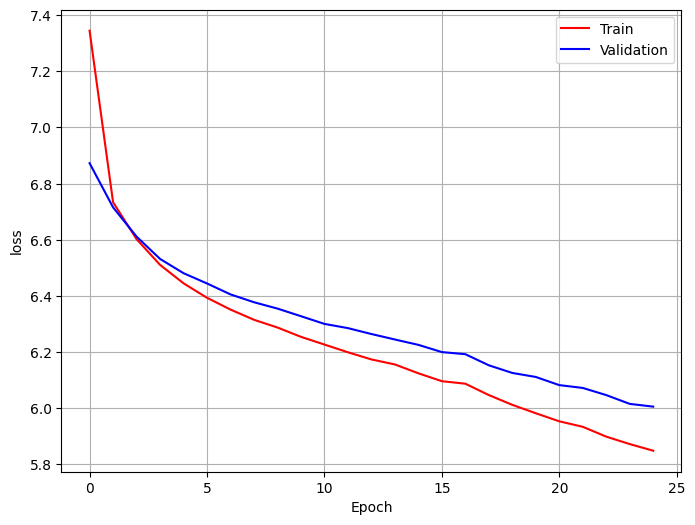

In [55]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

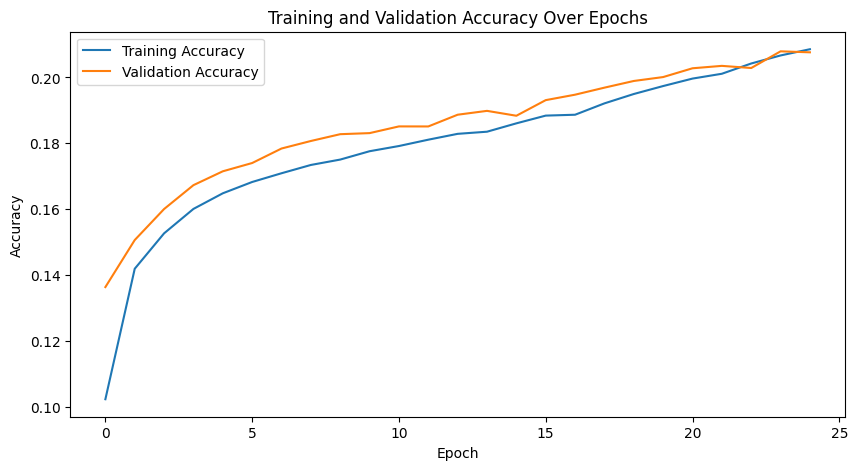

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(metric_train_hist, label='Training Accuracy')
plt.plot(metric_valid_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [57]:
model_path = 'model.pt' 
model = torch.load(model_path).to(device)
model.eval()  

loss_fn = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"]).to(device)

metric = torchmetrics.Accuracy(task='multiclass', num_classes=vocab_size).to(device)
metric.reset() 

loss_test, metric_test = evaluate(
    model=model,
    loader=test_loader,  
    loss_func=loss_fn,        
    metric=metric             
)

print(f'Test Loss: {loss_test:.4f}, Test Accuracy: {metric_test:.4f}')

Test Loss: 6.0242, Test Accuracy: 0.2058


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [58]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embed): Embedding(66061, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=256, out_features=66061, bias=True)
)

In [71]:
import torch
import numpy as np

def generate_text(prompt, max_length, temperature, model, tokenizer, vocab, seed_value=None):
    """
    Generates text based on a given prompt using a trained language model.

    Args:
        prompt (str): Initial text string to seed generation.
        max_length (int): Maximum number of tokens to generate.
        temperature (float): Controls randomness; higher = more diverse outputs.
        model (nn.Module): Trained language model.
        tokenizer (callable): Function to tokenize the prompt into tokens.
        vocab (Vocab or dict): Vocabulary mapping tokens to indices and vice versa.
        seed_value (int, optional): Seed for reproducibility.

    Returns:
        str: The generated text sequence.
    """
    if seed_value is not None:
        torch.manual_seed(seed_value)
        np.random.seed(seed_value)

    prompt_tokens = tokenizer(prompt)
    prompt_indices = [vocab[token] for token in prompt_tokens]
    input_tensor = torch.tensor(prompt_indices, dtype=torch.long).unsqueeze(0).to(device)

    model.eval()
    generated_sequence = input_tensor.clone()

    with torch.no_grad():
        for _ in range(max_length):
            output_logits = model(generated_sequence)
            
            last_token_logits = output_logits[:, -1, :]
            
            scaled_logits = last_token_logits / temperature

            probs = torch.softmax(scaled_logits, dim=-1)

            next_token = torch.multinomial(probs, num_samples=1)

            generated_sequence = torch.cat([generated_sequence, next_token], dim=1)

            if next_token.item() == vocab["<eos>"]:
                break

    full_token_list = generated_sequence.squeeze().tolist()
    decoded_tokens = [vocab.lookup_token(tok_id) for tok_id in full_token_list]

    output_text = " ".join(decoded_tokens)
    return output_text


In [74]:
prompt = "this is a test from Deep learning"
max_seq_len = 30
temperature = 1.0

generated_text = generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=42)

print("Generated Text:")
print(generated_text)

Generated Text:
this is a test from deep learning by the band . = = = = 2009 and wolfpack = = = = in 2014 , a writing of the northern dihydride mcneil period played a 1 @
